In [1]:

%pip install yfinance
%pip install scipy
import yfinance as yf
import pandas as pd
import numpy as np
asset = "^RUT" 
spread_method = lambda x,y:(x-y)/((x+y)/2) # how to get spread?
spread_threshold = 0.1 # data with spread over spread_threshold should be removed 
maturity_depth = 1 # data with maturity over maturity_depth should be removed
tic = yf.Ticker(asset)
call_df = tic.option_chain().calls
hist = tic.history(period="1d")
underlyingPrice = hist["Close"].iloc[-1]

short_rate = 0.04 #Use real data T-bill rate!!!!
medium_rate = 0.05
long_rate = 0.06

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
#Get volatility
#$$C(S,t)=S_t\Phi(d_1)-e^{-r(T-t)}K\Phi(d_2)$$
#$$d_1=\frac{\log(\frac{S_t}{K})+(r+\sigma^2/2)(T-t)}{\sigma\sqrt{T-t}}$$
#$$d_2=d_1-\sigma\sqrt{T-t}$$
from scipy.stats import norm
from scipy.optimize import brentq

def bs_call_price(S,T,r,K,sigm):
    """
    INPUT-->
    S:current underlying price
    T:maturity
    r:neutral rate
    K:strike
    sigm:vol
    
    OUTPUT-->
    Black-Scholes call option price(constant neutral rate)
    """
    if T <= 0 or sigm <= 0:
        return max(0, S - K)
    d1=(np.log(S/K)+T*(r+sigm**2/2))/(sigm*np.sqrt(T))
    d2=d1-sigm*np.sqrt(T)
    C=S*norm.cdf(d1)-np.exp(-r*T)*K*norm.cdf(d2)

    return C


def implied_vol_finder(C_,S,T,r,K):
    """
    INPUT-->
    C_:market call price
    S:current underlying price
    T:maturity
    r:neutral rate
    K:strike

    OUTPUT-->
    volatility, such that C_=C
    with brentq method!
    """
    difference = lambda sigm: bs_call_price(S,T,r,K,sigm) - C_

    try:
        implied_vol = brentq(difference, a = 1e-6, b = 500.0)
        return implied_vol
    except ValueError:
        return np.nan

In [3]:
from datetime import datetime, date
from dateutil.relativedelta import relativedelta
date_today = date.today()
maturity_threshold = date_today + relativedelta(years = maturity_depth) 
date_ava = np.array([date(*(int(y) for y in x.split("-"))) for x in tic.options])
nday = sum(date_ava < maturity_threshold)

# initialise empty list taking dataframes containing data with the same maturity 
single_maturity_data = []

for n in range(nday):
    maturity_date = list(tic.options)[n]
    call_dayn_df = tic.option_chain(maturity_date).calls[["lastPrice", "strike","bid", "ask", "openInterest", "volume"]]

    # remove garbage data
    call_dayn_df = call_dayn_df[call_dayn_df.bid>0]
    call_dayn_df = call_dayn_df[spread_method(call_dayn_df.ask,call_dayn_df.bid)<=spread_threshold]

    # get price/strike/maturity and weights (openInterest/volume)
    price_mean = (call_dayn_df.ask + call_dayn_df.bid)/2
    call_pricen_df = call_dayn_df[["openInterest", "volume", "lastPrice"]] 
    call_pricen_df.insert(0, "price_mean", price_mean)
    call_pricen_df.insert(0, "K_strike", call_dayn_df.strike)
    T = ((date(*(int(x) for x in maturity_date.split("-"))) - date_today).days)/365
    call_pricen_df.insert(0, "T_maturity", T)  
    single_maturity_data.append(call_pricen_df)

data_today = pd.concat(single_maturity_data)
rate_s = short_rate*(data_today.T_maturity <= 0.25)
rate_m = medium_rate*((data_today.T_maturity > 0.25)*(data_today.T_maturity <=1))
rate_l = long_rate*(data_today.T_maturity >1)
rate = rate_s+rate_m+rate_l
data_today.insert(0, "rate", rate)
data_today.insert(0, "underlyingPrice", underlyingPrice)
iv = data_today.apply(lambda row:implied_vol_finder(
    row["price_mean"],
    row["underlyingPrice"],
    row["T_maturity"],
    row["rate"],
    row["K_strike"]
    ),
    axis=1)

data_today.insert(0, "IV", iv)

,IV,underlyingPrice,rate,T_maturity,K_strike,price_mean,openInterest,volume,lastPrice
0,NaN,2633.26001,0.04,0.000000,2430.0,192.5,25,25.0,80.18
1,NaN,2633.26001,0.04,0.000000,2440.0,182.0,25,25.0,71.61
2,NaN,2633.26001,0.04,0.000000,2450.0,171.7,0,5.0,94.84
3,NaN,2633.26001,0.04,0.000000,2455.0,167.0,1,1.0,73.43
4,NaN,2633.26001,0.04,0.000000,2465.0,157.5,1,1.0,64.18
...,...,...,...,...,...,...,...,...,...
46,0.178427,2633.26001,0.05,0.931507,3400.0,27.4,29,34.0,27.70
0,NaN,2633.26001,0.05,0.967123,1450.0,1207.0,3,1.0,1178.64
1,0.175133,2633.26001,0.05,0.967123,2500.0,326.0,200,NaN,271.30
2,0.176137,2633.26001,0.05,0.967123,2550.0,295.0,4,NaN,242.40


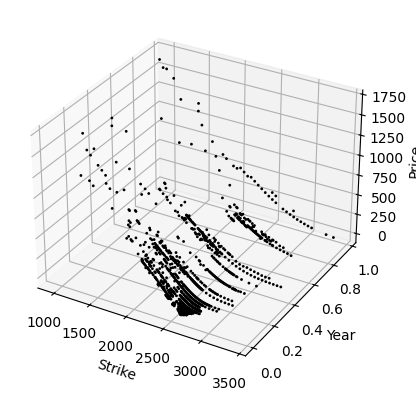

In [4]:

# Plot (x,y,z)=(K,T,price_mean) and save
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(projection = "3d")
ax.scatter(list(data_today.K_strike), list(data_today.T_maturity), list(data_today.price_mean), s = 1, color = "black", alpha=1);
ax.set_xlabel("Strike")
ax.set_ylabel("Year")
ax.set_zlabel("Price")
fig.savefig("KTP_plot.svg")
data_today

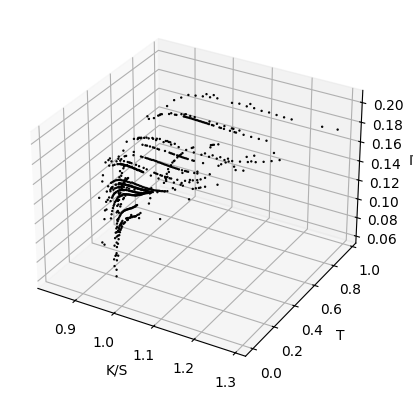

In [5]:

#Plot implied volatility surface
fig = plt.figure()
axes = fig.add_subplot(projection = "3d")
axes.scatter(list(data_today.K_strike/underlyingPrice),list(data_today.T_maturity), list(data_today.IV),s=0.5, color = "black", alpha=1)
axes.set_zlabel("IV")
axes.set_xlabel("K/S")
axes.set_ylabel("T")
fig.savefig("IVplot.svg")